# `DDI-LLM:`
**Exploring Language-based Drug Chemical Structure Embedding Methods for Drug-Drug Interaction Prediction via Graph Convolutional Networks**
---
`Drug-drug interactions (DDIs)` can arise when multiple drugs are used to treat complex or concurrent medical conditions, potentially leading to alterations in how these drugs work. Consequently, predicting DDIs has become a crucial endeavour within medical machine learning, addressing a critical aspect of healthcare.

This paper explores the application of language-based embeddings, including `BERT`, `GPT`,`LLaMA`, and `LLaMA2,` within the context of `Graph Convolutional Networks (GCN)` to enhance DDI prediction.

We start by harnessing these advanced language models to generate embeddings for drug chemical structures and drug descriptions, providing a more comprehensive representation of drug characteristics. These embeddings are subsequently integrated into a DDI network, with GCN employed for link prediction. We utilize BERT, GPT, and LLaMA embeddings to improve the accuracy and effectiveness of predicting drug interactions within this network.

Our experiments reveal that using language-based drug embeddings in combination with DDI structure embeddings can yield accuracy levels comparable to state-of-the-art methods in DDI prediction.






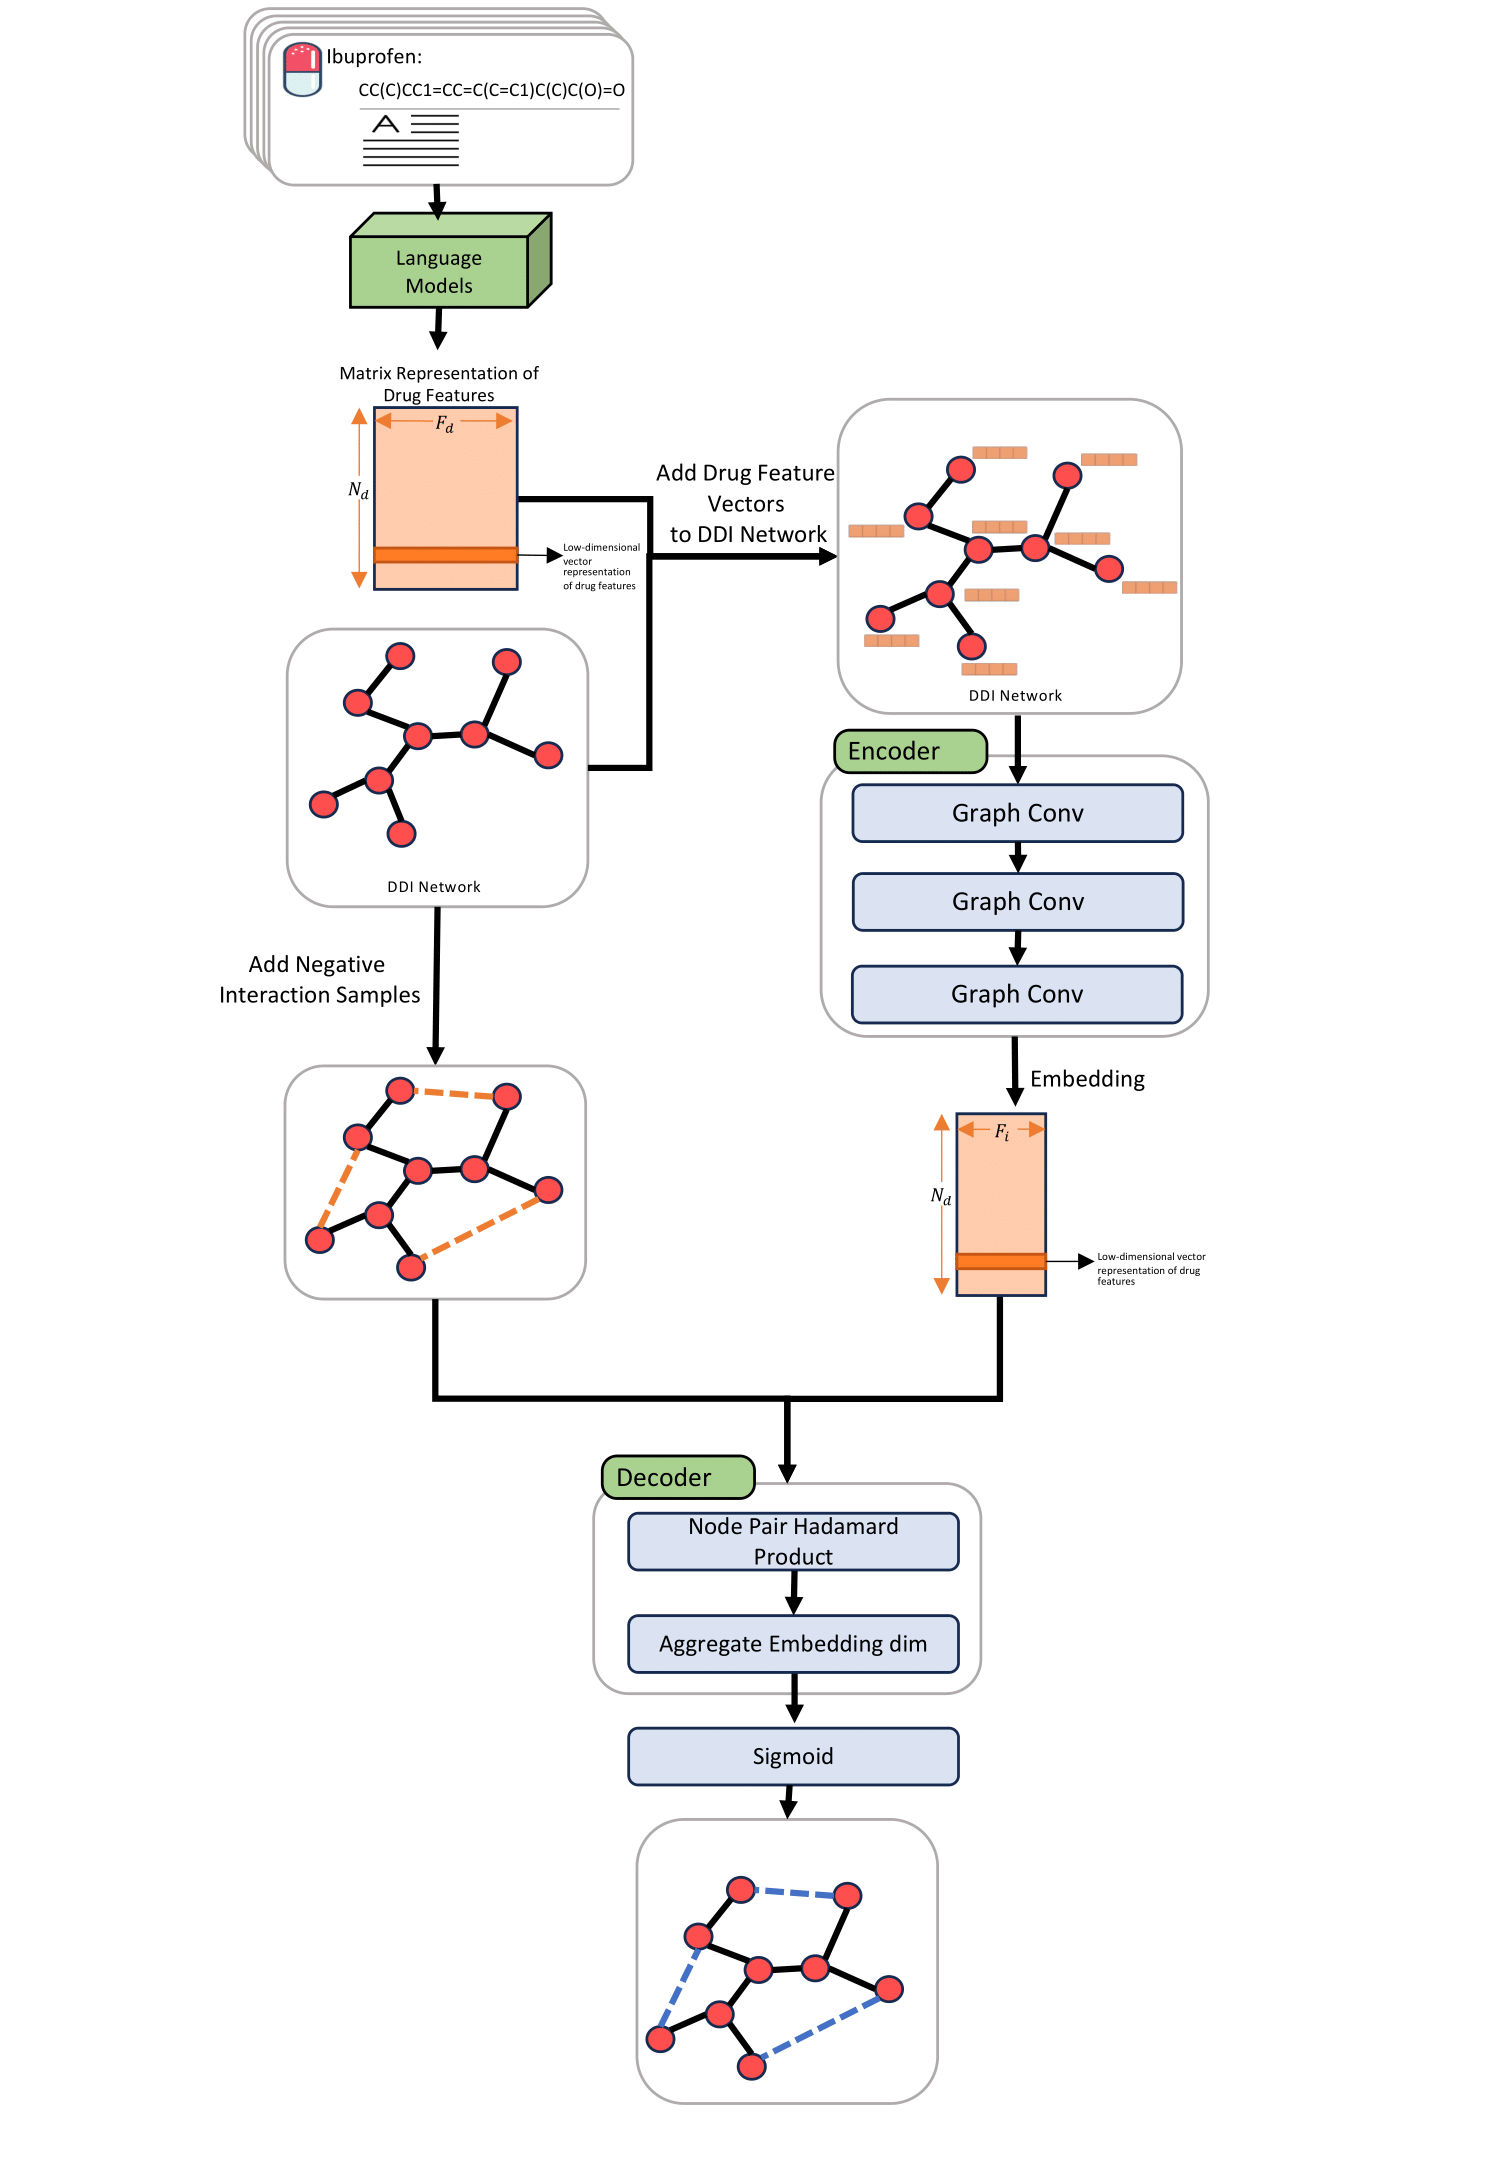


## 1-   Setup



You need to have `Python >= 3.8` and install the following main packages:

In [ ]:
%%capture
!pip install torch_geometric
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install dgl
!pip install rdkit
!pip install deepchem
!pip install gensim
!pip install git+https://github.com/samoturk/mol2vec
!pip install transformers


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import random
import os.path as osp
from rdkit import Chem
import deepchem as dc
from deepchem.feat.smiles_tokenizer import BasicSmilesTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
import torch_geometric.transforms as T
from torch_geometric.utils import negative_sampling, convert, to_dense_adj
from torch_geometric.nn import GCNConv, SAGEConv
from torch_geometric.nn.conv import MessagePassing

import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import ExponentialLR,MultiplicativeLR
from torch import Tensor
from torch.utils.data import DataLoader

from gensim.models import word2vec
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import pickle

from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec
import torch
from sklearn.metrics import roc_auc_score ,auc,precision_recall_curve,f1_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')


## 2- Reading DDI dataset
---

This code read two data files, one for `DDI graph` and one for `drug info`. We take the intersection of the datasets, resulting a graph where each node has `SMILES`, `drug name`, and `drug description`.


Input data:

* DDI network: It is a graph where nodes are drug IDs. There are 48514 edges, about `1514` unique `drugIDs`. Raw data from [`BioSnap`](https://snap.stanford.edu/biodata/datasets/10001/10001-ChCh-Miner.html)

Ref: [`MIRACLE`](https://arxiv.org/pdf/2010.11711.pdf)
* `Drug ID-SMILES:` 11583 pairs of (DrugID, SMILES). [`DrugBank`](https://go.drugbank.com/releases/latest#structures)
* `Drug ID-Desc:` 15235 pairs of (DrugID, SMILES) that we extracted from the DrugBANK database.

* **`NOTE:`** Certain SMILES strings in our drug dataset do not represent valid molecules, as determined by the RDKit library. Consequently, to maintain the accuracy and reliability of our graphs, we must exclude these drugs that lack valid information.

In [ ]:
DDI_graph = pd.read_csv('https://raw.githubusercontent.com/liiniix/BioSNAP/master/ChCh-Miner/ChCh-Miner_durgbank-chem-chem.tsv', sep='\t')
#DDI_graph = pd.read_csv('https://raw.githubusercontent.com/sshaghayeghs/molSMILES/main/drugbankDDI.csv', sep=',')

#save the raw data as our own data so that we do not depend on other apis.
DDI_graph.rename(columns={'Drug1': 'src', 'Drug2': 'dst'}, inplace=True)
DrugIDs_in_graph = np.unique(DDI_graph.values) # there are 1514 unique drugs in the graph

DDI_graph

,src,dst
0,DB00862,DB00966
1,DB00575,DB00806
2,DB01242,DB08893
3,DB01151,DB08883
4,DB01235,DB01275
...,...,...
48509,DB00542,DB01354
48510,DB00476,DB01239
48511,DB00621,DB01120
48512,DB00808,DB01356


### 2-1- Properties of the BioSnap graph
* The largest connected components has `1510` nodes in it
* Number of nodes: `1514`
* Number of edges: `48514`
* Is undirected: `True`
* Average node degree: `64.087`
* Has isolated nodes: `False`
* Has self-loops: `False`


In [ ]:
G = nx.from_pandas_edgelist(DDI_graph, 'src', 'dst')

In [ ]:
# Find the connected components
connected_components = nx.connected_components(G)

for component in connected_components:
    subgraph = G.subgraph(component)
    print("Subgraph Nodes:", subgraph.nodes())
    print("Subgraph Edges:", subgraph.edges())
    print("Subgraph Length:", len(subgraph))
    print()

In [ ]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
is_undirected = G.is_directed() is False
average_node_degree = sum(dict(G.degree()).values()) / num_nodes

has_isolated_nodes = any(deg == 0 for _, deg in G.degree())
has_self_loops = any(G.has_edge(n, n) for n in G.nodes())

# Print the results
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Is undirected: {is_undirected}")
print(f"Average node degree: {average_node_degree}")
print(f"Has isolated nodes: {has_isolated_nodes}")
print(f"Has self-loops: {has_self_loops}")

Number of nodes: 1514
Number of edges: 48514
Is undirected: True
Average node degree: 64.08718626155878
Has isolated nodes: False
Has self-loops: False


`edge_index` is an important property that we will need for building GNNs. It is a list of edges with shape `[2, |E|]`. Important: since `ddi_graph` is undirected, $E$ includes both $(u, v)$ and $(v, u)$ for two drugs $u$ and $v$ that interact.

Note that there are no node features, so we will need to address this when building our model.

### 2-2-Reading the SMILES strings
---

In [ ]:
drugsSMILES = pd.read_csv('https://raw.githubusercontent.com/sshaghayeghs/molSMILES/main/structure%20links%202.csv')
drugID_smiles = drugsSMILES[["DrugBank ID", "SMILES"]]
drugID_smiles.dropna(inplace=True)
drugID_smiles.reset_index(drop=True, inplace=True)

<ipython-input-12-26bacc5df7ac>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drugID_smiles.dropna(inplace=True)


### 2-3- Reading Drug Description

In [ ]:
drugsDESC = pd.read_csv('https://raw.githubusercontent.com/sshaghayeghs/molSMILES/main/Drug_description.csv')
drugID_DESC = drugsDESC[["Drug ID", "Discription"]]
drugID_DESC.dropna(inplace=True)
drugID_DESC.reset_index(drop=True, inplace=True)

<ipython-input-13-c2147157fec6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drugID_DESC.dropna(inplace=True)


### 2-4- Cleaning the DDI network
Droping drugs with `invalid` smiles strings

* In our `drugID_smiles` dataset, some `SMILES` strings do not correspond to valid molecules according to `RDKit`. Our goal is to ensure the integrity of our ddi network by removing these non-valid drugs.

* Droping the drugs that do not have any correspond drug description.

In [ ]:
#checking if a molecule has a valid molecule corespodn to the smiles string
def is_valid_molecule(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None
    except:
        return False

In [ ]:
valid_smiles = pd.DataFrame(drugID_smiles)
valid_smiles['IsValidMolecule'] = drugID_smiles['SMILES'].apply(is_valid_molecule)
df_valid_molecules = valid_smiles[valid_smiles['IsValidMolecule']]

# Drop the temporary 'IsValidMolecule' column
df_valid_molecules = df_valid_molecules.drop(columns=['IsValidMolecule'])

[00:40:23] Explicit valence for atom # 0 N, 4, is greater than permitted
[00:40:23] Explicit valence for atom # 0 N, 4, is greater than permitted
[00:40:23] Explicit valence for atom # 0 N, 4, is greater than permitted
[00:40:24] Explicit valence for atom # 13 Cl, 5, is greater than permitted
[00:40:24] SMILES Parse Error: syntax error while parsing: OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]
[00:40:24] SMILES Parse Error: Failed parsing SMILES 'OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]' for input: 'OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]'
[00:40:24] Explicit valence for atom # 19 O, 3, is greater than permitted
[00:

In [ ]:

allowed_drug=[list(df_valid_molecules['DrugBank ID']),list(drugID_DESC['Drug ID'])]
# There are 1278 drugIDs that occur in the graph. Some graph nodes do not have associated SMILES or drug description

#droping the links that do not have any SMILES
for l in allowed_drug:
  for index, row in DDI_graph.iterrows():
      # Check if both cells in the row are in the allowed cells list
      if row['src'] not in l or row['dst'] not in l:
          # If either cell is not in the allowed cells list, remove the row
          DDI_graph.drop(index, inplace=True)



In [ ]:
#27800 edges
DDI_graph=DDI_graph.reset_index(drop=True)


In [ ]:
G = nx.from_pandas_edgelist(DDI_graph, 'src', 'dst')

In [ ]:
# Find the connected components
connected_components = nx.connected_components(G)

for component in connected_components:
    subgraph = G.subgraph(component)
    print("Subgraph Nodes:", subgraph.nodes())
    print("Subgraph Edges:", subgraph.edges())
    print("Subgraph Length:", len(subgraph))
    print()

In [ ]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
is_undirected = G.is_directed() is False
average_node_degree = sum(dict(G.degree()).values()) / num_nodes

has_isolated_nodes = any(deg == 0 for _, deg in G.degree())
has_self_loops = any(G.has_edge(n, n) for n in G.nodes())

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Is undirected: {is_undirected}")
print(f"Average node degree: {average_node_degree}")
print(f"Has isolated nodes: {has_isolated_nodes}")
print(f"Has self-loops: {has_self_loops}")


Number of nodes: 1320
Number of edges: 41577
Is undirected: True
Average node degree: 62.99545454545454
Has isolated nodes: False
Has self-loops: False


In [ ]:
#save the drugs smiles and drug description in the networks into a new dataframe
drugID_smiles_ddi = drugID_smiles[drugID_smiles['DrugBank ID'].isin(list(np.unique(DDI_graph.values)))]
drugID_smiles_ddi=drugID_smiles_ddi.reset_index(drop=True)
drugID_DESC_ddi = drugID_DESC[drugID_DESC['Drug ID'].isin(list(np.unique(DDI_graph.values)))]
drugID_DESC_ddi=drugID_DESC_ddi.reset_index(drop=True)



In [ ]:
drugID_DESC_ddi

,Drug ID,Discription
0,DB00006,Bivalirudin is a synthetic 20 residue peptide ...
1,DB00007,Leuprolide is a synthetic 9-residue peptide an...
2,DB00014,"Goserelin is a synthetic hormone. In men, it s..."
3,DB00035,"Desmopressin (dDAVP), a synthetic analogue of ..."
4,DB00080,Daptomycin is a cyclic lipopeptide antibacteri...
...,...,...
1315,DB11248,Zinc gluconate is a zinc salt of gluconic acid...
1316,DB11256,Levomefolic acid (INN) is the metabolite of fo...
1317,DB11315,Methscopolamine is a quaternary ammonium deriv...
1318,DB00873,;;;;


In [ ]:
drugID_smiles_ddi

,DrugBank ID,SMILES,IsValidMolecule
0,DB00006,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...,True
1,DB00007,CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=...,True
2,DB00014,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,True
3,DB00035,NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...,True
4,DB00080,CCCCCCCCCC(=O)N[C@@H](CC1=CNC2=C1C=CC=C2)C(=O)...,True
...,...,...,...
1315,DB11248,[Zn++].[H][C@@](O)(CO)[C@@]([H])(O)[C@]([H])(O...,True
1316,DB11256,CN1[C@@H](CNC2=CC=C(C=C2)C(=O)N[C@@H](CCC(O)=O...,True
1317,DB11315,C[N+]1(C)[C@H]2C[C@@H](C[C@@H]1[C@H]1O[C@@H]21...,True
1318,DB00873,[H][C@@]12CC[C@](O)(C(=O)OCCl)[C@@]1(C)C[C@H](...,True


## 3- Creating graph object for PyG
---
A data object describing a homogeneous graph. The data object can hold node-level, link-level and graph-level attributes. In general, Data tries to mimic the behavior of a regular Python dictionary. In addition, it provides useful functionality for analyzing graph structures, and provides basic PyTorch tensor functionalities.
[ref](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.Data.html#torch_geometric.data.Data)

In [ ]:
def PyG_data(feature,DDI_graph):
  DrugIDs_in_graph = np.unique(DDI_graph.values)
  node_id_map = {node_name: i for i, node_name in enumerate(DrugIDs_in_graph)}
  # Replace node names with integer IDs in the edge list
  src = [node_id_map[node_name] for node_name in DDI_graph['src']]
  dst = [node_id_map[node_name] for node_name in DDI_graph['dst']]
  # Stack the arrays side by side to create a 2D array
  combined_array = np.column_stack((np.array(src), np.array(dst)))
  edge_index = []  # List of tuples representing edges between drugs
  for drug_1, drug_2 in combined_array:
    # Create an undirected graph by adding edges in both directions
    edge_index.append((drug_1, drug_2))
    edge_index.append((drug_2, drug_1))
  #Replace node names with integer IDs in the feature
  feature=torch.tensor(feature,dtype=torch.float32)
  data = Data(x=feature, edge_index=torch.tensor(edge_index).t().contiguous())
  return data

## 4-Link Split
---
For this link prediction task, we want to randomly split links/edges into train, valid, and test data. We can use the `RandomLinkSplit` module from PyG to do that.

The split is performed such that the training split does not include edges in validation and test splits; and the validation split does not include edges in the test split.

[ref](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.transforms.RandomLinkSplit.html#torch_geometric.transforms.RandomLinkSplit)

In [ ]:
transform = RandomLinkSplit(num_val=0.2,
    num_test=0.2,
    is_undirected=True,
    add_negative_train_samples=False,
    neg_sampling_ratio=1.0)
#train_data, val_data, test_data = transform(data)

There are several things to note about this output data.

First, the split is performed on `edge_index` such that the training and the validation splits do not include the edges from the validation and the test split (i.e. only have the edges from the training split), and the test split does not include the edges from the test split. This is because `edge_index` (and `x`) is used for the encoder to create node embeddings, and this setup ensures that there are no target leaks on the node embeddings when it makes predictions on the validation/test data.

Second, two new attributes (`edge_label` and `edge_label_index`) are added to each split data. They are the edge labels and the edge indices corresponding to each split. `edge_label_index` will be used for the decoder to make predictions and `edge_label` will be used for model evaluation.

Third, negative links are added to both `val_data` and `test_data` with the same number as the positive links (`neg_sampling_ratio=1.0`). They are added to `edge_label` and `edge_label_index` attributes, but not added to `edge_index` as we do not want to use the negative links on the encoder (or node embedding creation). And also, we are not adding negative links to the training set here (with `add_negative_train_samples=False`) as we will add them during the training loop in `train_link_predictor` above. This randomization during training makes the model more robust.

The image below summarizes how this edge split is performed for the encoder and the decoder (the colored edges are used in each stage).

* **Positive edges** are edges that exist in the graph: the set $\{(u, v) \in E\}$, where $u, v \in V$.
* **Negative edges** are edges that don't exist in the graph: the set $\{(u, v) \notin E\}$.

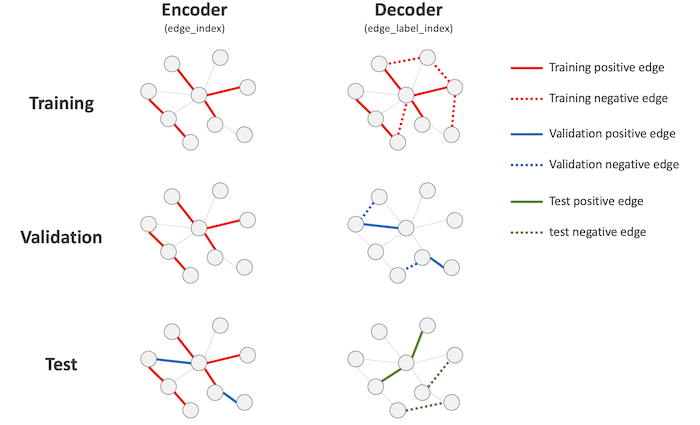

## 5- Drug Information Representation
---
**`Goal:`**
   * to encode the interactive information based on the `graph-structured data` with the `node content`

    * Both interactive `(intra-view)` and content information `(inter-view)` can be treated as two different views for a node in the graph.

**`Limitation:`**

* Most existing multi-view models apply naive view combination strategies, such as weighted average, add, and multi-view matrix factorization.
* Most of them are unsupervised and usually used to deal with the homogeneous network.

***GCN integrates the inter-view drug embedding vectors with the external DDI relationships.***


**In this experiments we evaluate the performance of `drug's information` embedding while using the `ddi graph structure`.**

The features that we use are `text-based information` of the drugs, including SMILES strings and Drug Description

### 5-1- No Feature

In [ ]:
def no_feature(smiles,DDI_graph):
  #DrugIDs_in_graph = np.unique(DDI_graph.values)
  features = np.ones((len(smiles),100))
  print('no_feature')
  return features,DDI_graph

### 5-2- SMILES-based embedding

#### 5-2-1- Morgan Fingerprint

In [ ]:
def Morgan(smiles,DDI_graph):
  featurizer = dc.feat.CircularFingerprint(size=100, radius=1)
  dataset=smiles['SMILES']
  features = pd.DataFrame(columns = [i for i in range(100)])
  for i in range(len(dataset)):
    features.loc[i] = featurizer.featurize(dataset[i])[0]
  print('Morgan')
  return features.values,DDI_graph

#### 5-2-2- Mol2vec


In [ ]:
def Mol2Vec(smiles,DDI_graph):
  featurizer = dc.feat.Mol2VecFingerprint()
  features=pd.DataFrame(columns = [i for i in range(300)])
  for s in smiles['SMILES']:
    features.loc[len(features)]=np.array(featurizer.featurize(s))[0]
  print('mol2vec')
  return features.values,DDI_graph

#### 5-2-3- SPVec

In [ ]:
def character2vec(smiles,DDI_graph):
  tokenizer = BasicSmilesTokenizer()
  corpus=[]
  for s in smiles['SMILES']:
      corpus.append(tokenizer.tokenize(s))
  model= Word2Vec(corpus,
          vector_size=300,
          window=20,
          min_count=0,
          sg=1,
          epochs=5)
  aa_sentences = [tokenizer.tokenize(x) for x in smiles['SMILES']]
  vec=sentences2vec(aa_sentences, model,300)
  print('character2vec')
  return vec.values,DDI_graph

#### 5-2-4- Doc2vec
ref:[gensim](https://radimrehurek.com/gensim/models/doc2vec.html)

In [ ]:
def doc2vec(SMILES,DDI_graph):
  tagged_documents = [TaggedDocument(doc.split(), [i]) for i, doc in enumerate(SMILES['SMILES'])]

  model = Doc2Vec(tagged_documents, vector_size=100, min_count=1, epochs=20)

  feature = [model.infer_vector(doc.split()) for doc in SMILES['SMILES']]
  #feature=pd.DataFrame(embeddings,index=new_df['DrugBank ID'])
  print('doc2vec')
  return feature,DDI_graph

#### 5-2-5-Language models

In [ ]:
allowed_drug=list(df_valid_molecules['DrugBank ID'])+list(drugID_DESC['Drug ID'])
def LM(DDI_graph,allowed_drug,model_name,dir):
    Drug=pd.read_csv(dir, sep='\t',index_col=0)
    if 'Unnamed: 0' in Drug.columns:
      Drug.drop(columns='Unnamed: 0', inplace=True)
    df = Drug[Drug.iloc[:, 0].isin(allowed_drug)]
    df=df.reset_index(drop=True)
    if 'Discription' in df.columns:
      features=df.drop(df.columns[[0, 1, 2]], axis=1)
    else:
      features=df.drop(df.columns[[0, 1]], axis=1)
    print(model_name)
    return  features.values, DDI_graph

##6- GCN (Multi-view representation Fusion)
---

1.   An encoder creates node embeddings by processing the graph with two
convolution layers.
2.   We randomly add negative links to the original graph. This makes the model task a binary classification with the positive links from the original edges and the negative links from the added edges.
3.   A decoder makes link predictions (i.e. binary classifications) on all the edges including the negative links using node embeddings.# Models


[Ref](https://github.com/pyg-team/pytorch_geometric/blob/master/examples/link_pred.py)

This setup is from [the original link prediction implementation in Variational Graph Auto-Encoders](https://github.com/tkipf/gae). The code looks like something below. This is adapted from [the code example in PyG repo](https://github.com/pyg-team/pytorch_geometric/blob/master/examples/link_pred.py) which is based on the Graph Auto-Encoders implementation.

The total number of the GCN encoder is 3.  To further regularise the model, dropout with 𝑝 = 0.3 is applied to every intermediate layer’s output.
[MIRACLE](https://arxiv.org/pdf/2010.11711.pdf)

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
    def encode(self, x, edge_index):
        x=self.conv1(x, edge_index)
        x=F.dropout(x, p=0.3)
        x=F.relu(x)
        x=self.conv2(x, edge_index)
        x=F.dropout(x, p=0.3)
        x=F.relu(x)
        x=self.conv3(x, edge_index)
        return x

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(
            dim=-1
        )  # product of a pair of nodes on each edge

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [ ]:
def train():
    model.train()
    optimizer.zero_grad()

    z = model.encode(train_data.x, train_data.edge_index) # initializing GCN model
    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    scheduler.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    roc=roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())
    label=data.edge_label.cpu().numpy()
    score=out.cpu().numpy()
    return roc,label,score

##7- Training and Evaluation
---

We can now train and evaluate the model with the following code.




In [ ]:
Embedding_models={'no_feature':no_feature(drugID_smiles_ddi,DDI_graph),
                  'Morgan':Morgan(drugID_smiles_ddi,DDI_graph),
                  'Mol2vec':Mol2Vec(drugID_smiles_ddi,DDI_graph),
                  'SPVec':character2vec(drugID_smiles_ddi,DDI_graph),
                  'Doc2vec':doc2vec(drugID_smiles_ddi,DDI_graph),
                  'BERTSMILES':LM(DDI_graph,allowed_drug,'BERT+SMILES','/content/drive/MyDrive/Shaghayegh Sadeghi/Drug embedding/DrugBank SMILES Embedding/BERT/bert50mt_base_SMILES_embeddings.csv'),
                  'GPTSMILES':LM(DDI_graph,allowed_drug,'GPT+SMILES','/content/drive/MyDrive/Shaghayegh Sadeghi/Drug embedding/DrugBank SMILES Embedding/GPT/SMILES_GPT.csv'),
                  'LLaMASMILES':LM(DDI_graph,allowed_drug,'LLaMA+SMILES','/content/drive/MyDrive/Shaghayegh Sadeghi/Drug embedding/DrugBank SMILES Embedding/LLaMA/llama65b_base_SMILES_embeddings.csv'),
                  'LLaMA2SMILES':LM(DDI_graph,allowed_drug,'LLaMA2+SMILES','/content/drive/MyDrive/Shaghayegh Sadeghi/Drug embedding/DrugBank SMILES Embedding/LLaMA II/llamaII7b_base_SMILES_embeddings.csv'),
                  'BERTDesc':LM(DDI_graph,allowed_drug,'BERT+Desc','/content/drive/MyDrive/Shaghayegh Sadeghi/Drug embedding/DrugBank Description Embedding/BERT/bert50mt_base_Discription_embeddings.csv'),
                  'GPTDesc':LM(DDI_graph,allowed_drug,'GPT+Desc','/content/drive/MyDrive/Shaghayegh Sadeghi/Drug embedding/DrugBank Description Embedding/GPT/Dr_Desc_GPT.csv'),
                  'LLaMADesc':LM(DDI_graph,allowed_drug,'LLaMA+Desc','/content/drive/MyDrive/Shaghayegh Sadeghi/Drug embedding/DrugBank Description Embedding/LLaMA/llama65b_base_Discription_embeddings.csv'),
                  'LLaMA2Desc':LM(DDI_graph,allowed_drug,'LLaMA2+Desc','/content/drive/MyDrive/Shaghayegh Sadeghi/Drug embedding/DrugBank Description Embedding/LLaMA II/llamaII7b_base_Discription_embeddings.csv'),

                  }

no_feature
Morgan
mol2vec
character2vec
doc2vec
BERT+SMILES
GPT+SMILES
LLaMA+SMILES
LLaMA2+SMILES
BERT+Desc
GPT+Desc
LLaMA+Desc
LLaMA2+Desc


We set each parameter group’s learning rate using an exponentially decaying schedule with the initial learning rate 0.0001
and multiplicative factor 0.96. [MIRACLE](https://arxiv.org/pdf/2010.11711.pdf)

In [ ]:
lmbda = lambda epoch: 0.96

In [ ]:
LR=[0.01,0.001, 0.0001,0.0002,0.0003,0.00001]
modelname=['no_feature','Morgan','Mol2vec','SPVec','Doc2Vec',
          'BERTSMILES','GPTSMILES','LLaMASMILES','LLaMA2SMILES',
           'BERTDesc','GPTDesc','LLaMADesc','LLaMA2Desc']
AUC=pd.DataFrame(columns = ['0.01','0.001','0.0001','0.0002','0.0003','0.00001'])
PR=pd.DataFrame(columns = ['0.01','0.001','0.0001','0.0002','0.0003','0.00001'])
AUC['Embedding']=modelname
PR['Embedding']=modelname

for l in LR:
  results_AUC=pd.DataFrame()
  results_PR=pd.DataFrame()
  for modelname, emb in Embedding_models.items():
    print('-------------------------------')
    print('=========',modelname,'=========')
    print('-------------------------------')
    data=PyG_data(emb[0],emb[1])
    train_data, val_data, test_data = transform(data)
    model = Net(data.num_features, 256, 256).to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=l)
    scheduler = MultiplicativeLR(optimizer, lr_lambda=lmbda)
    criterion = torch.nn.BCEWithLogitsLoss()
    neg_edge_index = negative_sampling(
          edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
          num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
          [train_data.edge_label_index, neg_edge_index],
          dim=-1,
      )
    edge_label = torch.cat([
          train_data.edge_label,
          train_data.edge_label.new_zeros(neg_edge_index.size(1))
      ], dim=0)
    best_val_auc = final_test_auc = 0
    for epoch in range(1, 100):
        loss = train()
        val_auc = test(val_data)[0]
        test_auc = test(test_data)[0]
        label=test(test_data)[1]
        score=test(test_data)[2]
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            final_test_auc = test_auc
            best_scores=score
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}')

    precision, recall, thresholds = precision_recall_curve(label, best_scores)
    pr=auc(recall, precision)
    results_AUC=results_AUC.append({"Embedding":modelname,"AUC":final_test_auc},ignore_index = True)
    results_PR=results_PR.append({"Embedding":modelname,"PR_AUC": pr},ignore_index = True)
    del data
    del model

  AUC[str(l)]=results_AUC['AUC']
  PR[str(l)]=results_PR['PR_AUC']

-------------------------------
========= no_feature =========
-------------------------------
Epoch: 001, Loss: 12.2218, Val: 0.5064
Epoch: 002, Loss: 49.0233, Val: 0.8497
Epoch: 003, Loss: 2.3559, Val: 0.8538
Epoch: 004, Loss: 0.7160, Val: 0.8437
Epoch: 005, Loss: 0.6850, Val: 0.8363
Epoch: 006, Loss: 0.6647, Val: 0.8406
Epoch: 007, Loss: 0.6584, Val: 0.8492
Epoch: 008, Loss: 0.6561, Val: 0.8489
Epoch: 009, Loss: 0.6539, Val: 0.8482
Epoch: 010, Loss: 0.6511, Val: 0.8467
Epoch: 011, Loss: 0.6504, Val: 0.8437
Epoch: 012, Loss: 0.6489, Val: 0.8461
Epoch: 013, Loss: 0.6401, Val: 0.8439
Epoch: 014, Loss: 0.6367, Val: 0.8432
Epoch: 015, Loss: 0.6336, Val: 0.8450
Epoch: 016, Loss: 0.6295, Val: 0.8391
Epoch: 017, Loss: 0.6285, Val: 0.8462
Epoch: 018, Loss: 0.6237, Val: 0.8451
Epoch: 019, Loss: 0.6229, Val: 0.8449
Epoch: 020, Loss: 0.6165, Val: 0.8433
Epoch: 021, Loss: 0.6165, Val: 0.8375
Epoch: 022, Loss: 0.6183, Val: 0.8454
Epoch: 023, Loss: 0.6152, Val: 0.8427
Epoch: 024, Loss: 0.6162, Val

<ipython-input-24-aac94a311f5c>:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  feature=torch.tensor(feature,dtype=torch.float32)


Streaming output truncated to the last 5000 lines.
Epoch: 098, Loss: 84.6684, Val: 0.5020
Epoch: 099, Loss: 83.4589, Val: 0.5021
-------------------------------
========= SPVec =========
-------------------------------
Epoch: 001, Loss: 222.9916, Val: 0.5001
Epoch: 002, Loss: 199.5790, Val: 0.5000
Epoch: 003, Loss: 170.1847, Val: 0.5001
Epoch: 004, Loss: 156.3257, Val: 0.5000
Epoch: 005, Loss: 136.8832, Val: 0.5002
Epoch: 006, Loss: 123.2095, Val: 0.5002
Epoch: 007, Loss: 110.5447, Val: 0.5003
Epoch: 008, Loss: 97.8562, Val: 0.5007
Epoch: 009, Loss: 88.0979, Val: 0.5013
Epoch: 010, Loss: 82.7326, Val: 0.5015
Epoch: 011, Loss: 73.6637, Val: 0.5033
Epoch: 012, Loss: 70.9725, Val: 0.5039
Epoch: 013, Loss: 61.8134, Val: 0.5064
Epoch: 014, Loss: 55.7969, Val: 0.5081
Epoch: 015, Loss: 53.2604, Val: 0.5113
Epoch: 016, Loss: 49.6139, Val: 0.5155
Epoch: 017, Loss: 45.1761, Val: 0.5177
Epoch: 018, Loss: 42.7931, Val: 0.5224
Epoch: 019, Loss: 40.0641, Val: 0.5276
Epoch: 020, Loss: 38.1217, Val: 0

In [ ]:
AUC.to_csv('/content/drive/MyDrive/Shaghayegh Sadeghi/DDI_LM/AUC_BioSnap.csv')


In [ ]:
PR.to_csv('/content/drive/MyDrive/Shaghayegh Sadeghi/DDI_LM/PR_BioSnap.csv')

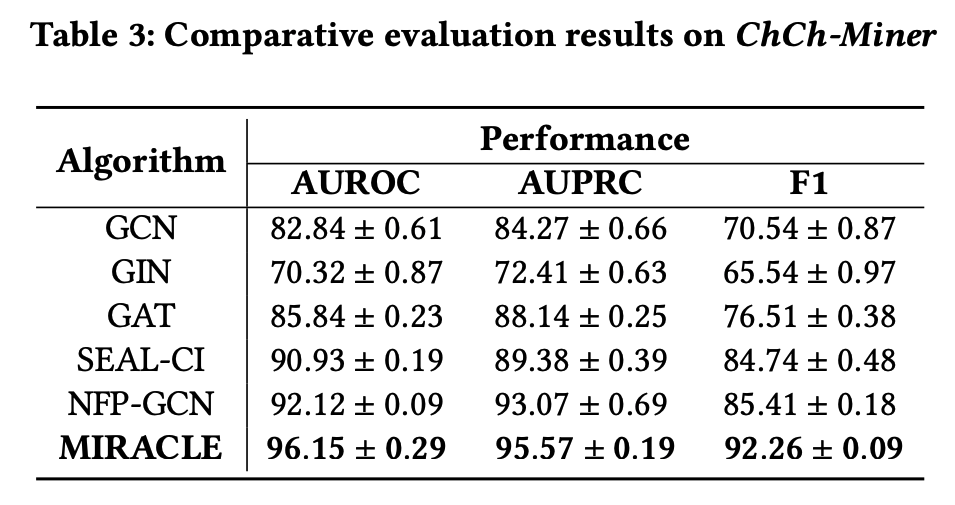

In [ ]:
AUC.index=AUC['Embedding']
AUC_edited=AUC.drop(['0.00001','Embedding'],axis=1)
AUC_edited

,0.01,0.001,0.0001,0.0002,0.0003,1e-05
Embedding,,,,,,
no_feature,0.859434,0.872158,0.871732,0.870277,0.875850,0.734971
Morgan,0.862855,0.881584,0.866916,0.879784,0.876142,0.867314
Mol2vec,0.856529,0.873553,0.502345,0.883751,0.898793,0.500000
SPVec,0.860429,0.868901,0.750297,0.879605,0.877897,0.500060
Doc2Vec,0.865263,0.866197,0.869623,0.858982,0.866473,0.851214
BERTSMILES,0.988011,0.992145,0.861696,0.965535,0.987598,0.486336
GPTSMILES,0.979758,0.995101,0.877138,0.937695,0.973288,0.711750
LLaMASMILES,0.965171,0.995707,0.857873,0.910590,0.952111,0.782804
LLaMA2SMILES,0.991647,0.995449,0.833849,0.900482,0.948034,0.776729


In [ ]:
PR.index=AUC['Embedding']
PR_edited=PR.drop(['0.00001','Embedding'],axis=1)
PR_edited

,0.01,0.001,0.0001,0.0002,0.0003,1e-05
Embedding,,,,,,
no_feature,0.842297,0.848567,0.849182,0.844213,0.858695,0.821540
Morgan,0.850882,0.861455,0.839200,0.857787,0.856000,0.837665
Mol2vec,0.849961,0.818349,0.750784,0.868166,0.864697,0.750000
SPVec,0.848413,0.837947,0.826274,0.858013,0.852334,0.750000
Doc2Vec,0.842982,0.844124,0.846915,0.839708,0.846166,0.806828
BERTSMILES,0.984607,0.992232,0.816725,0.964237,0.987170,0.500578
GPTSMILES,0.975305,0.995403,0.900572,0.947626,0.975836,0.770642
LLaMASMILES,0.936296,0.996421,0.873165,0.913344,0.951205,0.804284
LLaMA2SMILES,0.987353,0.994792,0.857682,0.912924,0.949117,0.817708


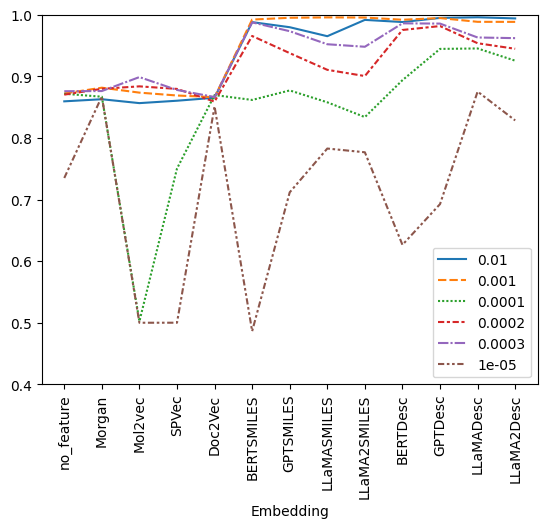

In [ ]:
ax=sns.lineplot(data=AUC_edited)
ax.set_ylim(0.4, 1)
ax.tick_params(axis='x', rotation=90)

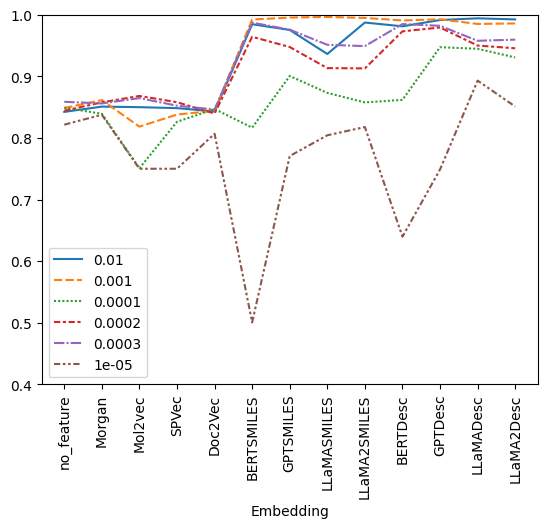

In [ ]:
ax=sns.lineplot(data=PR_edited)
ax.set_ylim(0.4, 1)
ax.tick_params(axis='x', rotation=90)

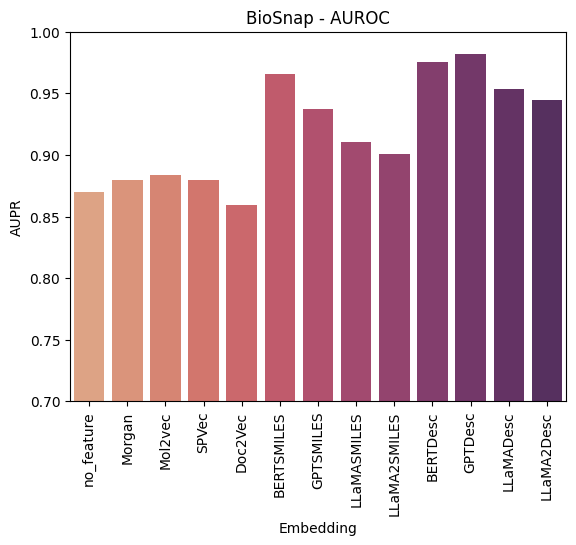

In [ ]:
ax=sns.barplot(x=AUC_edited.index, y='0.0002', data=AUC_edited,palette="flare")
ax.set_title('BioSnap - AUROC')
ax.set(ylabel='AUROC')
ax.set_ylim(0.7,1)
ax.tick_params(axis='x', rotation=90)

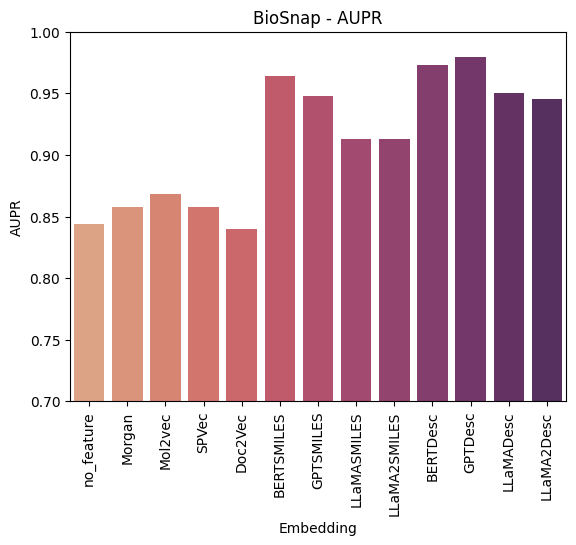

In [ ]:
ax=sns.barplot(x=PR_edited.index, y='0.0002', data=PR_edited,palette="flare")
ax.set_title('BioSnap - AUPR')
ax.set(ylabel='AUPR')
ax.set_ylim(0.7,1)
ax.tick_params(axis='x', rotation=90)
